In [1]:
# %matplotlib inline
import os 
import argparse
import random
from main import train
random.seed()
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #change to chosen GPU
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF


Using TensorFlow backend.


In [2]:

parser = argparse.ArgumentParser(description='Train model')                                                                       
parser.add_argument('--generator', type=str, default="upsampling", help="upsampling or deconv or subpixel")    
parser.add_argument('--discriminator', type=str, default="discriminator", help="discriminator discriminator_resnet")
parser.add_argument('--dset', type=str, default="VisDA2017", help="mnistM or washington_vandal50k or washington_vandal12classes")             
parser.add_argument('--img_dim', default=64, type=int, help="Image width == height")                           
parser.add_argument('--nb_epoch', default=500, type=int, help="Number of epochs")                              
parser.add_argument('--batch_size', default=64, type=int, help='Batch size for training purpose; for testing is hardcoded at 32')                                   
parser.add_argument('--n_batch_per_epoch', default=1000, type=int, help="Number of batch per epochs")           
parser.add_argument('--bn_mode', default=2, type=int, help="Batch norm mode")                                  
parser.add_argument('--noise_dim', default=100, type=int, help="noise sampler dimension")                      
parser.add_argument('--noise_scale', default=0.5, type=float, help="noise sampler variance")                   
parser.add_argument('--disc_iterations', default=5, type=int, help="Number of discriminator iterations")         
parser.add_argument('--opt_D', type=str, default="Adam", help="Optimizer for the discriminator")            
parser.add_argument('--opt_G', type=str, default="Adam", help="Optimizer for the generator")  
parser.add_argument('--opt_rec', type=str, default="Adam", help="Optimizer for the recostruction model")
parser.add_argument('--lr_D', type=float, default=1E-4, help="learning rate for the discriminator")            
parser.add_argument('--lr_G', type=float, default=1E-4, help="learning rate for the generator")  
parser.add_argument('--lr_rec', type=float, default=1E-4, help="learning rate for the recostruction model")
parser.add_argument('--use_mbd', action="store_true", help="use mini batch disc")
parser.add_argument('--deterministic1', action="store_true", help="remove the noise input to GAN1")
parser.add_argument('--deterministic2', action="store_true", help="remove the noise input to GAN2")
parser.add_argument('--inject_noise', action="store_true", help="inject noise into each layer")
parser.add_argument('--model', type=str, default="lsgan", help="wgan or lsgan") 
parser.add_argument('--no_supertrain', action="store_true", help="no discriminator supertraining") 
parser.add_argument('--pureGAN', action="store_true", help="no discriminator supertraining")
parser.add_argument('--lsmooth', type=float, default=1.0, help="label smoothing")
parser.add_argument('--monsterClass', action="store_true", help="Discriminator with 2x classes")
parser.add_argument('--disc_type', type=str, default="simple_disc", help="Discriminator type,between simple_disc or nclass_disc")
parser.add_argument('--resume', action="store_true", help="load GAN weights from previous train")
parser.add_argument('--name', type=str, default="mnist_mnistM_SGD", help="name of the run, used for saving and loading weights")
parser.add_argument('--wd', type=float, default=0.0, help="weight decay for generator/discriminator")
parser.add_argument('--history_size', type=float, default=1.8, help="history pool size = history_size * batch_size")
parser.add_argument('--data_aug', action="store_true", help="perform data augmentation on target dataset")
parser.add_argument('--reconst_w', type=float, default=1.0, help="reconstruction weight")
parser.add_argument('--rec', action="store_true", help="activate reconstruction between Gen1 and Gen2")
parser.add_argument('--reconstClass', type=float, default=0.0, help="activate reconstructionClass and set its weight")
parser.add_argument('--class_weight', type=float, default=1.0, help="class_weight")
parser.add_argument('--pretrained', action="store_true", help="use resnet50 pretrained on Imagenet")
parser.add_argument('--cArch', type=str, default="google", help="name of classifier architecture, google or signs")                           


args = parser.parse_args(' --img_dim 32 --cArch google  --dset mnist_to_svhn32 --model lsgan --history_size 1.5 --no_supertrain \
                          --disc_type nclass_disc --class_weight 1.0 --opt_D Adam --opt_G Adam \
                         --reconstClass 1.0 --batch_size 32 --disc_iterations 1 --wd 1E-3 --lr_D 1E-3 --lr_G 1E-3'.split())
######
print (args)

assert args.opt_G in ["RMSprop", "SGD", "Adam"], "Unsupported optimizer"                 
assert args.opt_D in ["RMSprop", "SGD", "Adam"], "Unsupported optimizer" 

# Set the backend by modifying the env variable                                                                
                                                                            
os.environ["KERAS_BACKEND"] = "tensorflow"  
import keras.backend as K                                                                           
image_dim_ordering = "tf"                                                                                  
K.set_image_dim_ordering(image_dim_ordering)

# Set default params
d_params = {"generator": args.generator,
            "discriminator": args.discriminator,
            "dset": args.dset,
            "img_dim": args.img_dim,
            "nb_epoch": args.nb_epoch,
            "batch_size": args.batch_size,
            "n_batch_per_epoch": args.n_batch_per_epoch,
            "bn_mode": args.bn_mode,
            "noise_dim": args.noise_dim,
            "noise_scale": args.noise_scale,
            "disc_iterations": args.disc_iterations,
            "lr_D": args.lr_D,
            "lr_G": args.lr_G,
            "lr_rec": args.lr_rec,
            "opt_rec": args.opt_rec,
            "opt_D": args.opt_D,
            "opt_G": args.opt_G,
            "use_mbd": args.use_mbd,
            "deterministic1": args.deterministic1,
            "deterministic2": args.deterministic2,
            "pureGAN": args.pureGAN,
            "lsmooth": args.lsmooth,
            "image_dim_ordering": image_dim_ordering,
            "model": args.model,
            "no_supertrain": args.no_supertrain,
            "monsterClass": args.monsterClass,
            "data_aug": args.data_aug,
            "disc_type": args.disc_type,
            "resume": args.resume,
            "name": args.name,
            "inject_noise": args.inject_noise,
            "history_size" : args.history_size,
            "reconst_w" : args.reconst_w,
            "class_weight" : args.class_weight,
            "rec" : args.rec,
            "reconstClass" : args.reconstClass,
            "pretrained" : args.pretrained,
            "cArch" : args.cArch,
            "wd" : args.wd
            }


Namespace(batch_size=32, bn_mode=2, cArch='google', class_weight=1.0, data_aug=False, deterministic1=False, deterministic2=False, disc_iterations=1, disc_type='nclass_disc', discriminator='discriminator', dset='mnist_to_svhn32', generator='upsampling', history_size=1.5, img_dim=32, inject_noise=False, lr_D=0.001, lr_G=0.001, lr_rec=0.0001, lsmooth=1.0, model='lsgan', monsterClass=False, n_batch_per_epoch=1000, name='mnist_mnistM_SGD', nb_epoch=500, no_supertrain=True, noise_dim=100, noise_scale=0.5, opt_D='Adam', opt_G='Adam', opt_rec='Adam', pretrained=False, pureGAN=False, rec=False, reconstClass=1.0, reconst_w=1.0, resume=False, use_mbd=False, wd=0.001)



Experiment parameters:
generator upsampling
discriminator discriminator
dset mnist_to_svhn32
img_dim 32
nb_epoch 500
batch_size 32
n_batch_per_epoch 1000
bn_mode 2
noise_dim 100
noise_scale 0.5
disc_iterations 1
lr_D 0.001
lr_G 0.001
lr_rec 0.0001
opt_rec Adam
opt_D Adam
opt_G Adam
use_mbd False
deterministic1 False
deterministic2 False
pureGAN False
lsmooth 1.0
image_dim_ordering tf
model lsgan
no_supertrain True
monsterClass False
data_aug False
disc_type nclass_disc
resume False
name mnist_mnistM_SGD
inject_noise False
history_size 1.5
reconst_w 1.0
class_weight 1.0
rec False
reconstClass 1.0
pretrained False
cArch google
wd 0.001


11493376/11490434 [==============================] - 33s 3us/step


/data/R_codes/SBADAGAN/models.py:77: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(5120, input_dim=(100,), kernel_regularizer=<keras.reg...)`
  x = Dense(5*s*s, input_dim=noise_dim,W_regularizer=l2(wd))(gen_noise_input)
/data/R_codes/SBADAGAN/models.py:86: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  g = merge([gen_image_input, x], mode='concat',concat_axis=3) # because of concat_axis=1, will it work on tensorflow NHWC too?
/usr/local/lib/python3.6/dist-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/data/R_codes/SBADAGAN/models.py:88: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same", kernel_regularizer=<keras.reg...)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
generator_input (InputLayer)    (None, 100)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 5120)         517120      generator_input[0][0]            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 32, 32, 5)    0           dense_1[0][0]                    
__________________________________________________________________________________________________
generator_image_input (InputLay (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
activation

/data/R_codes/SBADAGAN/models.py:139: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(5120, input_dim=(100,), kernel_regularizer=<keras.reg...)`
  x = Dense(5*s*s, input_dim=noise_dim,W_regularizer=l2(wd))(gen_noise_input)
/data/R_codes/SBADAGAN/models.py:148: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  g = merge([gen_image_input, x], mode='concat',concat_axis=3) # because of concat_axis=1, will it work on tensorflow NHWC too?
/usr/local/lib/python3.6/dist-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/data/R_codes/SBADAGAN/models.py:150: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same", kernel_regularizer=<keras.reg.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
generator_input (InputLayer)    (None, 100)          0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 5120)         517120      generator_input[0][0]            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 32, 32, 5)    0           dense_2[0][0]                    
__________________________________________________________________________________________________
generator_image_input (InputLay (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
activation

/data/R_codes/SBADAGAN/models.py:245: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(2, 2), name="disc_conv2d_1", kernel_initializer=<keras.ini..., kernel_regularizer=<keras.reg..., padding="same")`
  border_mode="same", kernel_initializer=RandomNormal(stddev=0.02),kernel_regularizer=l2(wd))(disc_input)
/data/R_codes/SBADAGAN/models.py:251: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), strides=(2, 2), name="disc_conv2d_2", kernel_initializer=<keras.ini..., kernel_regularizer=<keras.reg..., padding="same")`
  border_mode="same", kernel_initializer=RandomNormal(stddev=0.02),kernel_regularizer=l2(wd))(x)
/data/R_codes/SBADAGAN/models.py:251: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), strides=(2, 2), name="disc_conv2d_3", kernel_initializer=<keras.ini..., kernel_regularizer=<keras.reg..., padding="same")`
  border_mode="same", kernel_initializer=RandomNormal(stddev=0.02),kernel_r

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa (None, 32, 32, 3)         0         
_________________________________________________________________
disc_conv2d_1 (Conv2D)       (None, 16, 16, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
disc_conv2d_2 (Conv2D)       (None, 8, 8, 128)         73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 128)         32        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
__________

/data/R_codes/SBADAGAN/models.py:279: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(2, 2), name="disc_conv2d_1", kernel_initializer=<keras.ini..., kernel_regularizer=<keras.reg..., padding="same")`
  border_mode="same", kernel_initializer=RandomNormal(stddev=0.02),kernel_regularizer=l2(wd))(disc_input)
/data/R_codes/SBADAGAN/models.py:285: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), strides=(2, 2), name="disc_conv2d_2", kernel_initializer=<keras.ini..., kernel_regularizer=<keras.reg..., padding="same")`
  border_mode="same", kernel_initializer=RandomNormal(stddev=0.02),kernel_regularizer=l2(wd))(x)
/data/R_codes/SBADAGAN/models.py:285: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), strides=(2, 2), name="disc_conv2d_3", kernel_initializer=<keras.ini..., kernel_regularizer=<keras.reg..., padding="same")`
  border_mode="same", kernel_initializer=RandomNormal(stddev=0.02),kernel_r

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
discriminator_input (InputLayer (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
disc_conv2d_1 (Conv2D)          (None, 16, 16, 64)   1792        discriminator_input[0][0]        
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 16, 16, 64)   64          disc_conv2d_1[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_4 (LeakyReLU)       (None, 16, 16, 64)   0           batch_normalization_4[0][0]      
__________________________________________________________________________________________________
disc_conv2

/data/R_codes/SBADAGAN/models.py:334: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), strides=(1, 1), name="conv1", kernel_initializer="he_normal", kernel_regularizer=<keras.reg..., padding="same")`
  x = Conv2D(32, (5, 5), strides=(1, 1), name="conv1",border_mode="same", kernel_initializer="he_normal",kernel_regularizer=l2(wd))(input)
/data/R_codes/SBADAGAN/models.py:337: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(1, 1), name="conv2", kernel_initializer="he_normal", kernel_regularizer=<keras.reg..., padding="same")`
  x = Conv2D(48, (5, 5), strides=(1, 1), name="conv2",border_mode="same", kernel_initializer="he_normal",kernel_regularizer=l2(wd))(x)
/data/R_codes/SBADAGAN/models.py:341: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, activation="relu", name="fc1", kernel_initializer="he_normal", kernel_regularizer=<keras.reg...)`
  x = Dense(100, init="he_normal",activation="relu", name='f

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
classifier_input (InputLayer (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        2432      
_________________________________________________________________
activation_23 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 48)        38448     
_________________________________________________________________
activation_24 (Activation)   (None, 16, 16, 48)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 48)          0         
__________

/data/R_codes/SBADAGAN/models.py:334: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), strides=(1, 1), name="conv1", kernel_initializer="he_normal", kernel_regularizer=<keras.reg..., padding="same")`
  x = Conv2D(32, (5, 5), strides=(1, 1), name="conv1",border_mode="same", kernel_initializer="he_normal",kernel_regularizer=l2(wd))(input)
/data/R_codes/SBADAGAN/models.py:337: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(1, 1), name="conv2", kernel_initializer="he_normal", kernel_regularizer=<keras.reg..., padding="same")`
  x = Conv2D(48, (5, 5), strides=(1, 1), name="conv2",border_mode="same", kernel_initializer="he_normal",kernel_regularizer=l2(wd))(x)
/data/R_codes/SBADAGAN/models.py:341: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, activation="relu", name="fc1", kernel_initializer="he_normal", kernel_regularizer=<keras.reg...)`
  x = Dense(100, init="he_normal",activation="relu", name='f

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
classifier_input (InputLayer (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        2432      
_________________________________________________________________
activation_25 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 48)        38448     
_________________________________________________________________
activation_26 (Activation)   (None, 16, 16, 48)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 48)          0         
__________

/data/R_codes/SBADAGAN/models.py:494: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("di...)`
  output=DCGAN_output)
/data/R_codes/SBADAGAN/models.py:515: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("cl...)`
  output=DCGAN_output)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
noise_input (InputLayer)        (None, 100)          0                                            
__________________________________________________________________________________________________
image_input (InputLayer)        (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
generator_google1 (Model)       (None, 32, 32, 3)    817283      noise_input[0][0]                
                                                                 image_input[0][0]                
__________________________________________________________________________________________________
discriminator_domain (Model)    (None, 1)            373233      generator_google1[1][0]          
Total para

/data/R_codes/SBADAGAN/models.py:538: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="DCGAN", inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  name="DCGAN")
/data/R_codes/SBADAGAN/additional_models.py:77: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="zClass", inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  zclass_model = Model(input=[generator.layers[0].input,image_input],output=[x],name="zClass")


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
noise_input (InputLayer)        (None, 100)          0                                            
__________________________________________________________________________________________________
image_input (InputLayer)        (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
generator_google1 (Model)       (None, 32, 32, 3)    817283      noise_input[0][0]                
                                                                 image_input[0][0]                
__________________________________________________________________________________________________
discriminator (Model)           [(None, 1), (None, 1 414203      generator_google1[1][0]          
Total para

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Pretrain of discriminator finished.
31968/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0088 - Loss_D_gen1: 0.0067 - Loss_G1: 0.0709 - Loss_Classifier1: 0.1020 - Loss_Rec1: 0.1768 - Loss_GenClass1: 0.2075(128, 256, 3)


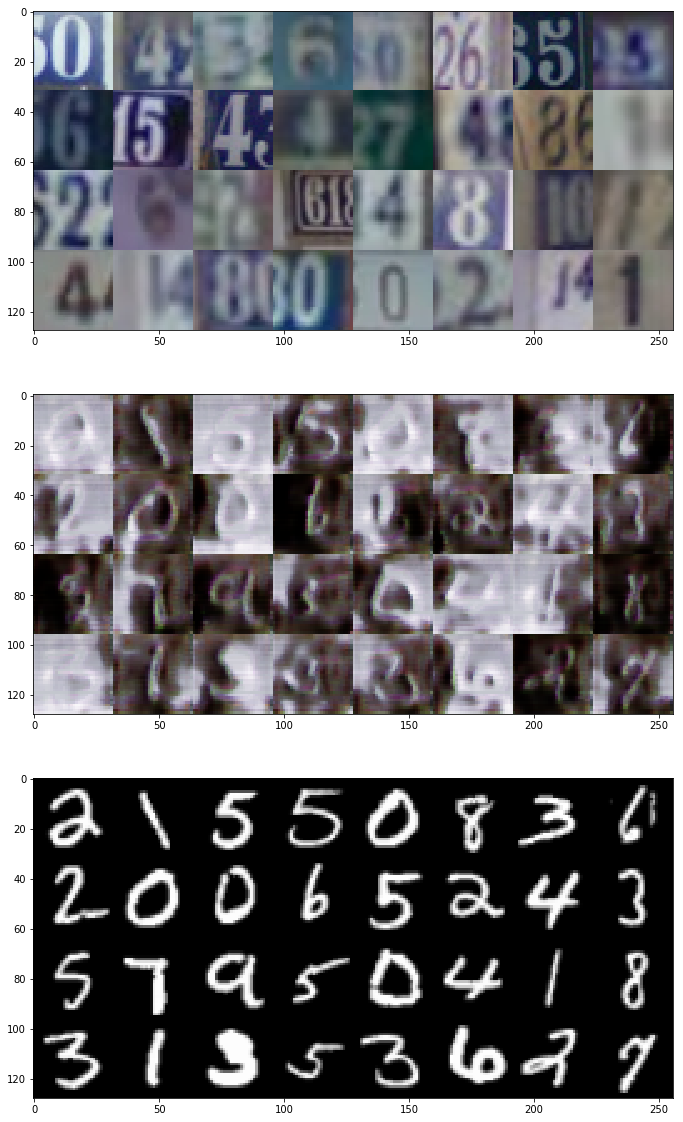

Dest labels:
[0 4 3 6 0 6 5 5 6 5 4 4 7 4 8 1 2 6 2 6 4 8 1 1 4 1 8 0 0 2 1 1]
Source labels:
[2 1 5 5 0 8 3 6 2 0 0 6 5 2 4 3 5 7 9 5 0 4 1 8 3 1 3 5 3 6 2 7]

Epoch 2, Time: 211.74129676818848
epoch 1, Saved weights!
26032/26032 [==============================] - 2s 73us/step

 Classifier Accuracy and loss on full target domain:  15.67%  
26032/26032 [==============================] - 1s 52us/step

 Classifier Accuracy and loss on full target domain:  13.26%  
31968/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0076 - Loss_D_gen1: 0.0059 - Loss_G1: 0.0820 - Loss_Classifier1: 0.0643 - Loss_Rec1: 0.0898 - Loss_GenClass1: 0.1631(128, 256, 3)


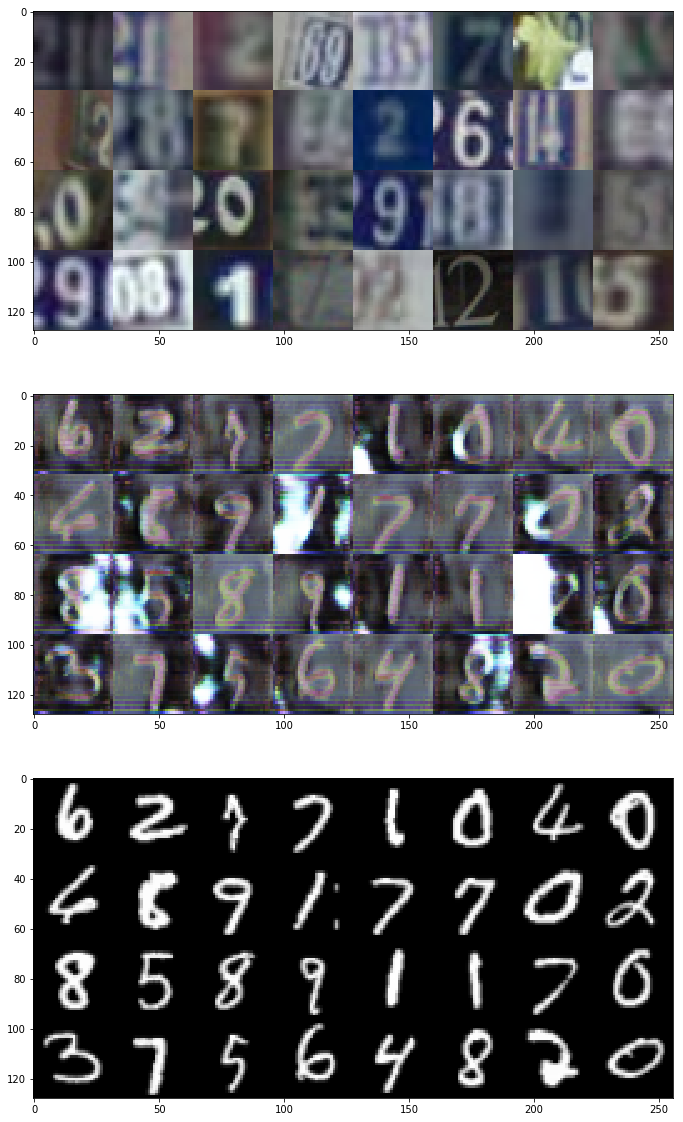

Dest labels:
[1 1 2 6 3 7 1 3 1 8 7 3 2 6 4 6 0 4 0 3 9 8 3 5 9 8 1 7 2 2 1 5]
Source labels:
[6 2 7 7 1 0 4 0 6 8 9 1 7 7 0 2 8 5 8 9 1 1 7 0 3 7 5 6 4 8 2 0]

Epoch 3, Time: 212.47865915298462
epoch 2, Saved weights!
26032/26032 [==============================] - 1s 45us/step

 Classifier Accuracy and loss on full target domain:  19.96%  
26032/26032 [==============================] - 1s 45us/step

 Classifier Accuracy and loss on full target domain:  15.20%  
31968/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0067 - Loss_D_gen1: 0.0071 - Loss_G1: 0.0968 - Loss_Classifier1: 0.0510 - Loss_Rec1: 0.0684 - Loss_GenClass1: 0.1696(128, 256, 3)


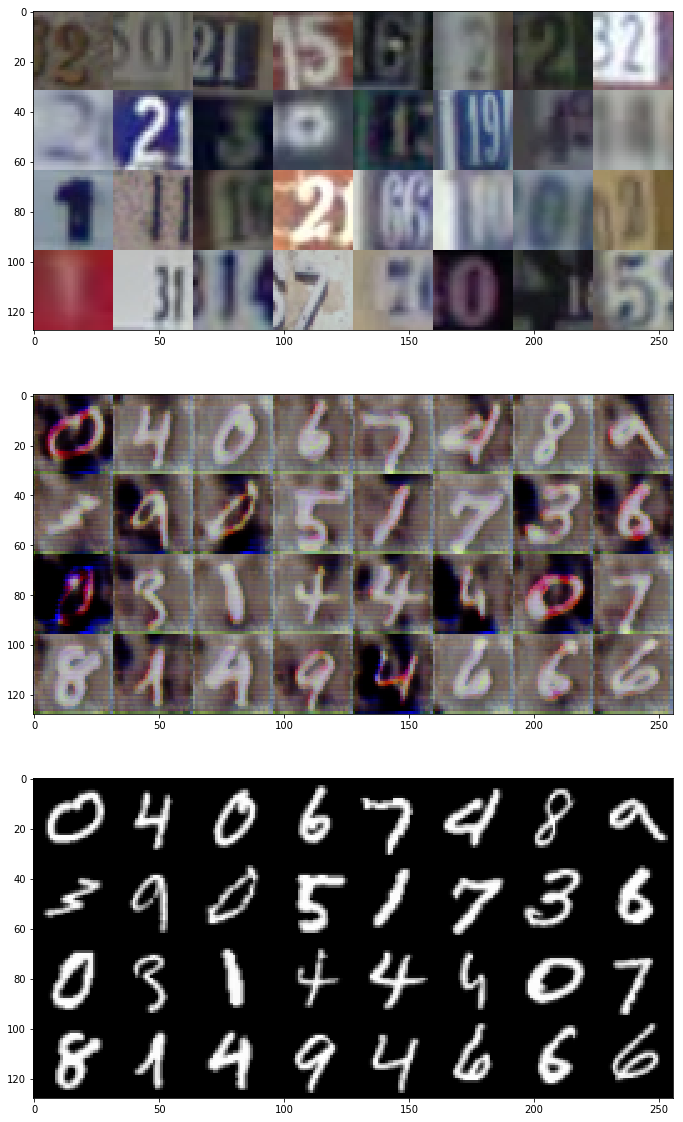

Dest labels:
[2 0 1 5 6 2 2 2 2 2 3 0 1 1 4 4 1 1 1 2 6 1 0 2 1 3 1 7 7 0 1 5]
Source labels:
[0 4 0 6 7 4 8 9 3 9 0 5 1 7 3 6 0 3 1 4 4 4 0 7 8 1 4 9 4 6 6 6]

Epoch 4, Time: 225.57849097251892
epoch 3, Saved weights!
26032/26032 [==============================] - 1s 46us/step

 Classifier Accuracy and loss on full target domain:  28.20%  
26032/26032 [==============================] - 1s 44us/step

 Classifier Accuracy and loss on full target domain:  12.10%  
31968/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0066 - Loss_D_gen1: 0.0052 - Loss_G1: 0.0909 - Loss_Classifier1: 0.0461 - Loss_Rec1: 0.0619 - Loss_GenClass1: 0.1471(128, 256, 3)


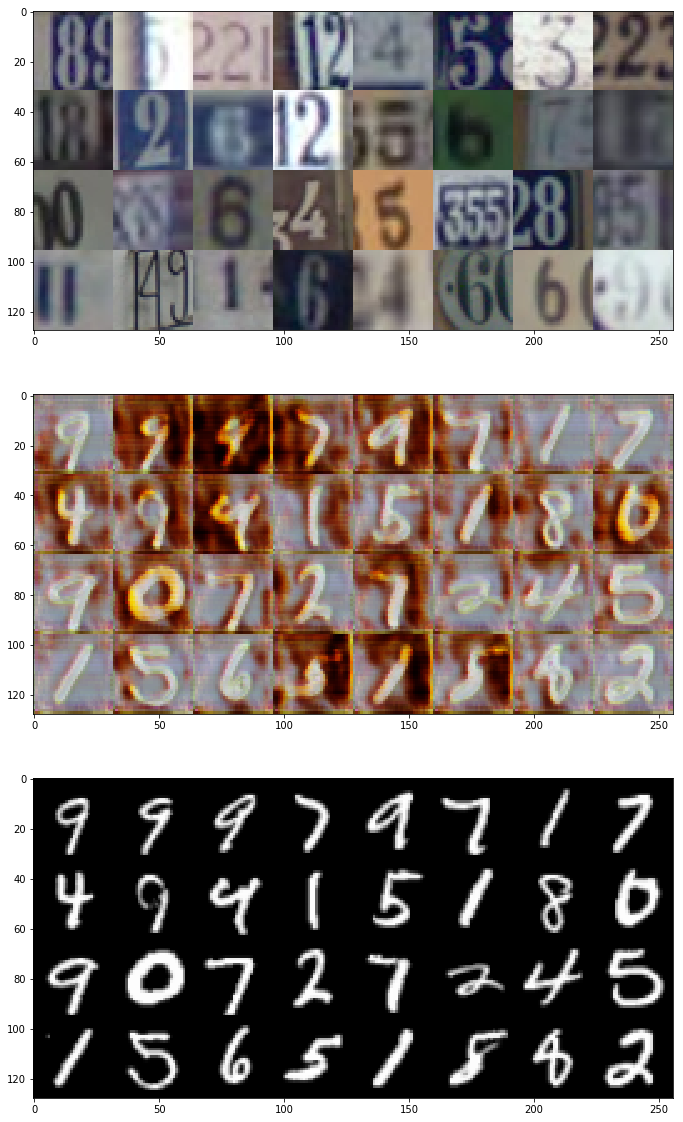

Dest labels:
[8 5 2 1 4 5 3 3 8 2 6 2 5 6 7 1 0 8 6 4 5 5 8 5 1 4 1 6 4 6 6 9]
Source labels:
[9 9 9 7 9 7 1 7 4 9 4 1 5 1 8 0 9 0 7 2 7 2 4 5 1 5 6 5 1 8 8 2]

Epoch 5, Time: 225.94678258895874
epoch 4, Saved weights!
26032/26032 [==============================] - 1s 44us/step

 Classifier Accuracy and loss on full target domain:  31.61%  
26032/26032 [==============================] - 1s 44us/step

 Classifier Accuracy and loss on full target domain:  13.43%  
31968/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0075 - Loss_D_gen1: 0.0059 - Loss_G1: 0.0837 - Loss_Classifier1: 0.0417 - Loss_Rec1: 0.0583 - Loss_GenClass1: 0.1259(128, 256, 3)


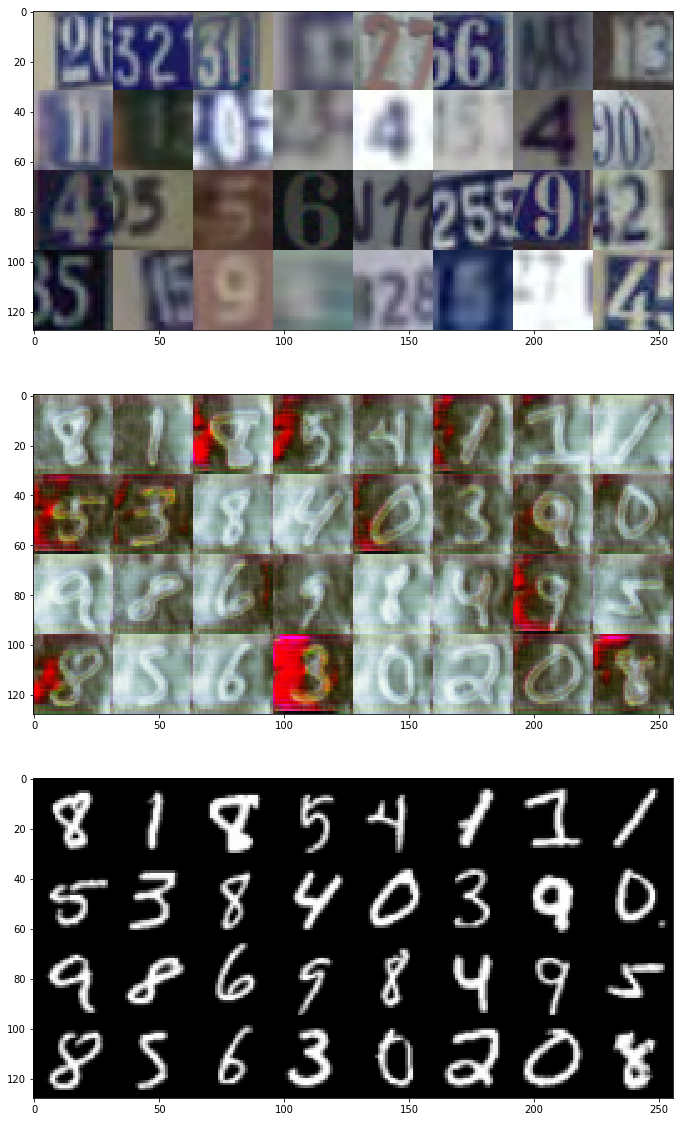

Dest labels:
[2 2 1 1 7 6 4 1 1 1 0 5 4 5 4 0 4 5 5 6 1 5 9 2 5 1 9 3 2 5 7 4]
Source labels:
[8 1 8 5 4 1 1 1 5 3 8 4 0 3 9 0 9 8 6 9 8 4 9 5 8 5 6 3 0 2 0 8]

Epoch 6, Time: 225.5688214302063
epoch 5, Saved weights!
26032/26032 [==============================] - 1s 44us/step

 Classifier Accuracy and loss on full target domain:  36.93%  
26032/26032 [==============================] - 1s 44us/step

 Classifier Accuracy and loss on full target domain:  14.52%  
31968/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0048 - Loss_D_gen1: 0.0045 - Loss_G1: 0.0867 - Loss_Classifier1: 0.0394 - Loss_Rec1: 0.0541 - Loss_GenClass1: 0.1259(128, 256, 3)


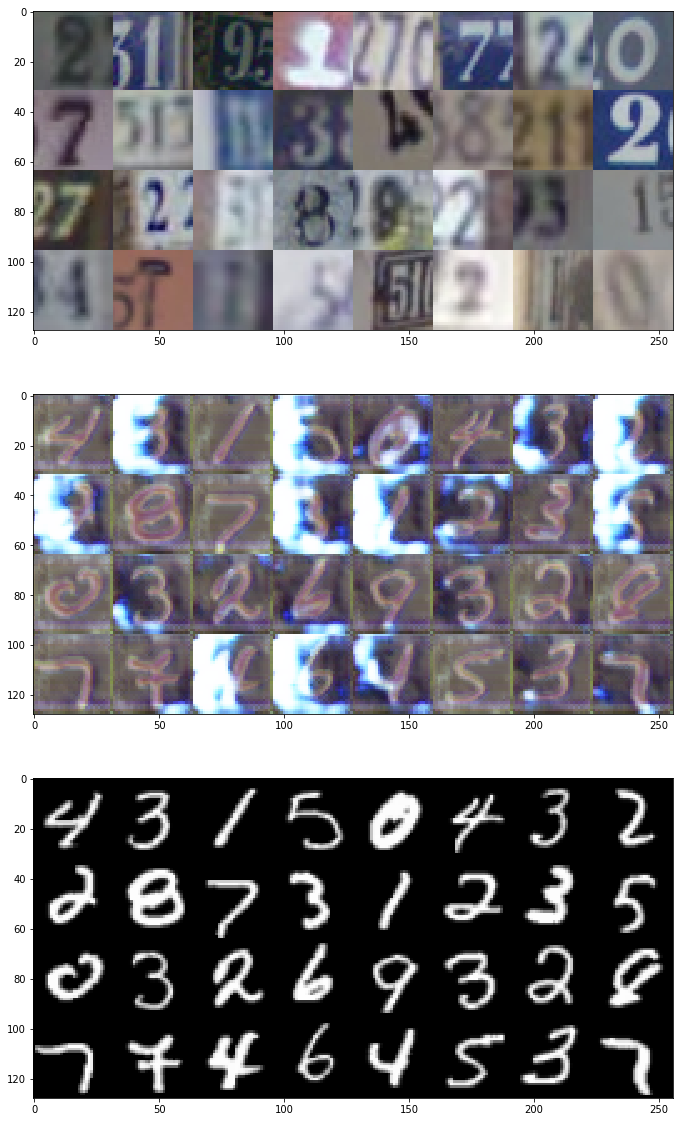

Dest labels:
[2 1 9 1 7 7 2 0 7 1 1 3 4 8 1 2 7 2 3 8 9 2 3 1 4 1 7 5 5 2 1 0]
Source labels:
[4 3 1 5 0 4 3 2 2 8 7 3 1 2 3 5 0 3 2 6 9 3 2 8 7 7 4 6 4 5 3 7]

Epoch 7, Time: 225.55209279060364
epoch 6, Saved weights!
26032/26032 [==============================] - 1s 44us/step

 Classifier Accuracy and loss on full target domain:  38.34%  
26032/26032 [==============================] - 1s 45us/step

 Classifier Accuracy and loss on full target domain:  12.57%  
31968/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0042 - Loss_D_gen1: 0.0041 - Loss_G1: 0.0858 - Loss_Classifier1: 0.0381 - Loss_Rec1: 0.0540 - Loss_GenClass1: 0.1190(128, 256, 3)


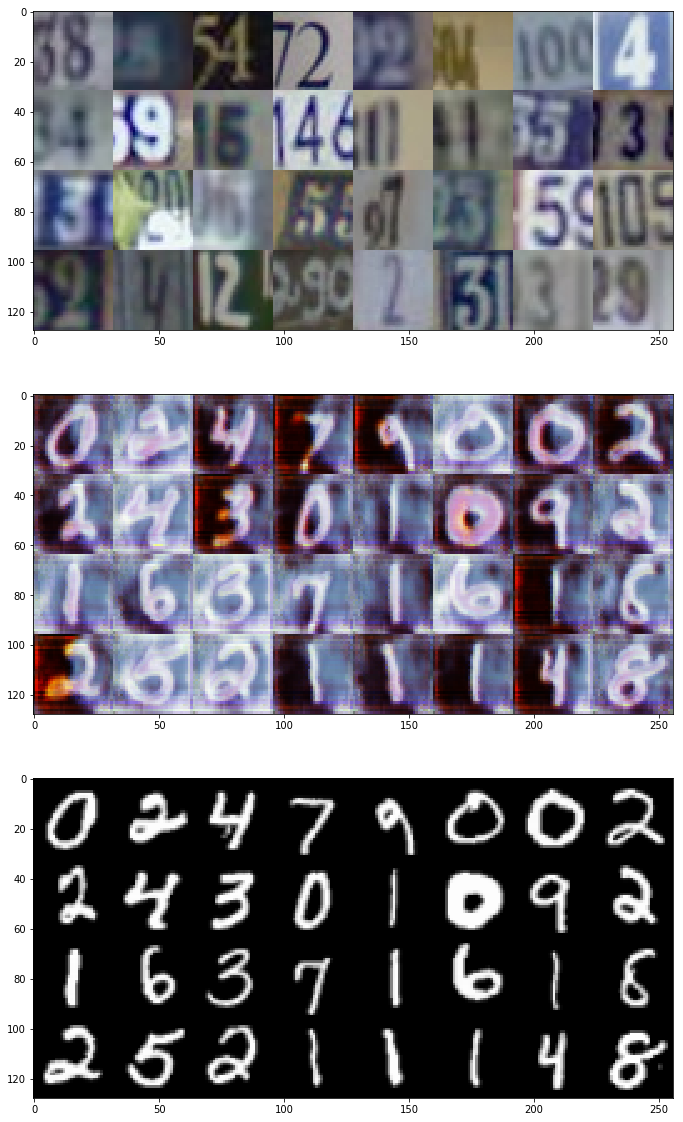

Dest labels:
[8 8 4 2 2 4 0 4 4 9 5 4 0 1 5 3 3 2 6 5 7 3 5 0 2 4 2 9 2 3 3 9]
Source labels:
[0 2 4 7 9 0 0 2 2 4 3 0 1 0 9 2 1 6 3 7 1 6 1 8 2 5 2 1 1 1 4 8]

Epoch 8, Time: 226.95471668243408
epoch 7, Saved weights!
26032/26032 [==============================] - 1s 45us/step

 Classifier Accuracy and loss on full target domain:  37.95%  
26032/26032 [==============================] - 1s 45us/step

 Classifier Accuracy and loss on full target domain:  11.01%  
31968/32000 [============================>.] - ETA: 0s - Loss_D_real1: 0.0045 - Loss_D_gen1: 0.0047 - Loss_G1: 0.0794 - Loss_Classifier1: 0.0335 - Loss_Rec1: 0.0499 - Loss_GenClass1: 0.1085(128, 256, 3)


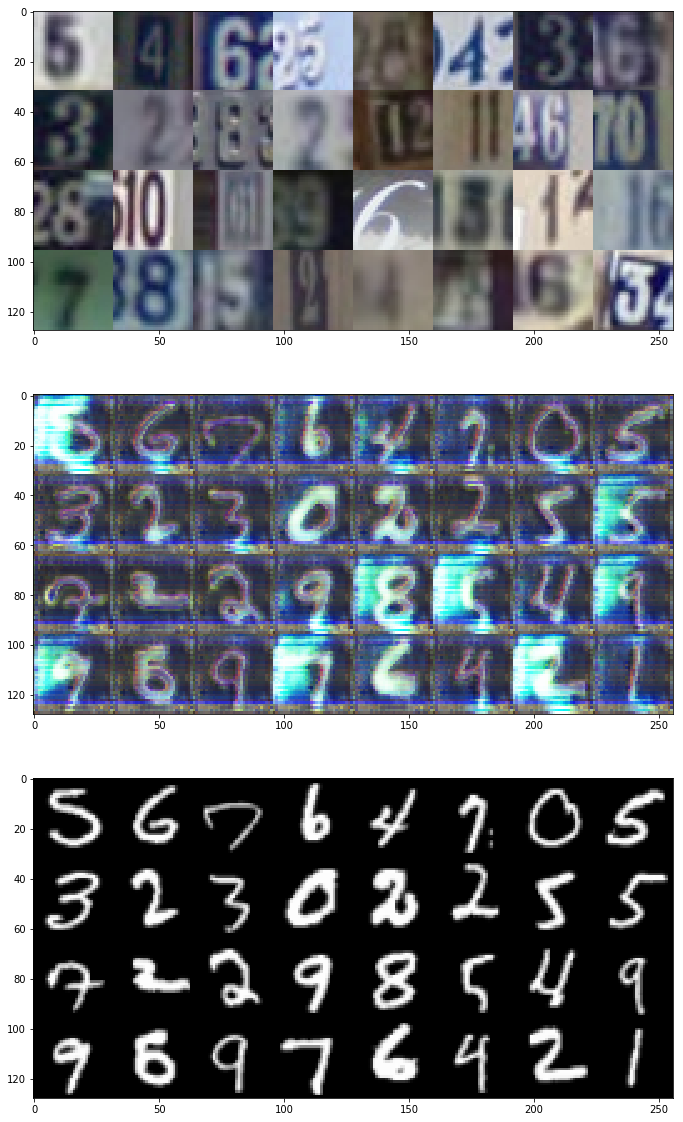

Dest labels:
[5 4 6 5 8 4 3 6 3 2 8 2 1 1 6 0 8 0 6 9 6 3 1 1 7 8 5 2 4 2 6 3]
Source labels:
[5 6 7 6 4 7 0 5 3 2 3 0 2 2 5 5 7 2 2 9 8 5 4 9 9 5 9 7 6 4 2 1]

Epoch 9, Time: 225.54785585403442
epoch 8, Saved weights!
26032/26032 [==============================] - 1s 45us/step

 Classifier Accuracy and loss on full target domain:  40.46%  
26032/26032 [==============================] - 1s 44us/step

 Classifier Accuracy and loss on full target domain:  9.89%  
14336/32000 [============>.................] - ETA: 2:05 - Loss_D_real1: 0.0038 - Loss_D_gen1: 0.0040 - Loss_G1: 0.0910 - Loss_Classifier1: 0.0324 - Loss_Rec1: 0.0486 - Loss_GenClass1: 0.1407

KeyboardInterrupt: 

In [3]:

# Launch training
train(**d_params)